In [1]:
from __future__ import print_function
import jsonlines
import re
import json
import nltk
import io
import numpy as np
from keras.layers import Embedding
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
# start - <sos> tag
# stop - <eos> tag

#split records into list of impression, findings
def splitReports(File):
    
    impression_list = []
    findings_list = []
    
    with open(File,'r') as file:
        for line in file:
            all = line
        
    report_list = re.findall(r'{.*?}',all)

    for report in report_list:
        obj = json.loads(report)
        # indication_list.append(str(obj['Indication']))
        impression_list.append('start ' + str(obj['impression']) + ' stop')
        findings_list.append(str(obj['findings']))
        
    return (findings_list, impression_list)    

In [3]:
#get vocab of indications, impression, findings
def getVocabularySets(findings_list, impression_list):
    # indication_vocab_set = set()
    impression_vocab_set = set()
    findings_vocab_set = set()
    common_vocab_set = set()

    #for item in indication_list:
     #   for word in nltk.word_tokenize(item):
      #      indication_vocab_set.add(word.lower())
        
    for item in impression_list:
        for word in nltk.word_tokenize(item):
            impression_vocab_set.add(word.lower())
        
    for item in findings_list:
        for word in nltk.word_tokenize(item):
            findings_vocab_set.add(word.lower())
        
    # common_vocab_set.update(indication_vocab_set)
    common_vocab_set.update(impression_vocab_set)
    common_vocab_set.update(findings_vocab_set)
    
    return (common_vocab_set, findings_vocab_set, impression_vocab_set)

In [4]:
# get the embedding  matrix
def loadGloVeModel(gloVe_file):
    embedding_model = {}
    
    with io.open(gloVe_file, encoding = 'utf8') as f:
        word_embeddings = f.readlines()
        
    for word_embedding_line in word_embeddings:
        word_embedding = word_embedding_line.split()
        word = word_embedding[0]
        embedding = np.array([float(col) for col in word_embedding[1:]])
        embedding_model[word] = embedding
            
    return embedding_model

In [5]:
#get max sequences 
def getMaxSeq(List):
        
    max_len = 0
    for item in List:
        item_len = len(item.split())
        if item_len > max_len:
            max_len = item_len
    
    return max_len

In [6]:
findings, impression = splitReports('reports.jsonl')
common_vocab, findings_vocab, impression_vocab = getVocabularySets(findings, impression)

common = []
common.extend(findings)
#common.extend(indications)
common.extend(impression)

#max_indication_len = getMaxSeq(indications)
findings_MAXLEN = getMaxSeq(findings)
impression_MAXLEN = getMaxSeq(impression)

MAXLEN = max(max_findings_len, max_impression_len)
#MAX_LEN = 100 #99

NameError: name 'max_findings_len' is not defined

In [7]:

#embedding_model = loadGloVeModel('radglove.800M.100d.txt')
#findings_MAXLEN
impression_MAXLEN

139

In [8]:
#embedding dimension
#EMBEDDING_DIM = 100

findings_MAXLEN

187

In [9]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(common)

#word_to_index = tokenizer.word_index

#indication_sequences = tokenizer.texts_to_sequences(indications)

#findings_sequences = tokenizer.texts_to_sequences(findings)
#impression_sequences = tokenizer.texts_to_sequences(impression)

#indication_data = pad_sequences(indication_sequences, maxlen = MAXLEN)

#findings_data = pad_sequences(findings_sequences, maxlen = MAX_LEN)
#impression_data = pad_sequences(impression_sequences, maxlen = MAX_LEN)

word_2_index = dict([(word, i) for i, word in enumerate(common_vocab)])

In [10]:
index_2_word = {}
for word,index in word_2_index.items():
    index_2_word[index] = word

In [11]:
embedding_model = loadGloVeModel('radglove.800M.100d.txt')

EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(common_vocab),EMBEDDING_DIM))
inverse_embedding_matrix = np.zeros((EMBEDDING_DIM, len(common_vocab)))

inverse_embedding_matrix = {}
for word,index in word_2_index.items():
    embedding_vector = embedding_model.get(word)
    
    if embedding_vector is not None :
        embedding_matrix[index] = embedding_vector

In [41]:
# check doc.s once
# trainable=False to prevent the weights from being updated during training
embedding_layer = Embedding(len(common_vocab), EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), trainable=False)

In [25]:
#verify tokenization

def getEmbeddingVec(word, embedding_matrix):
    # Get embedding matrix of a particular word 
    return embedding_matrix[word_2_index[word]]

def sampleToken(X, embedding_matrix):
    #Sample the word from embedding matrix
    for index,embedding_vec in enumerate(embedding_matrix):
        if cmp(X.tolist(),embedding_vec.tolist()) == 0:
            return index_2_word[index]

In [26]:
findings_data = np.zeros(
    (len(findings), findings_MAXLEN),
    dtype='float32')
impression_data = np.zeros(
    (len(impression), impression_MAXLEN),
    dtype='float32')
target_data = np.zeros(
    (len(impression), impression_MAXLEN),
    dtype='float32')

In [27]:
impression[0]

'start no acute cardiopulmonary abnormality . stop '

In [28]:
def toLowerCase(findings, impression):
    new_findings = []
    new_impression = []
    for sent in findings:
        new_sent = ""
        for word in sent.split():
            new_sent = new_sent + word.lower() + ' '
        new_findings.append(new_sent) 

    for sent in impression:
        new_sent = ""
        for word in sent.split():
            new_sent = new_sent + word.lower() + ' '
        new_impression.append(new_sent)
        
    return (new_findings, new_impression)

findings, impression = toLowerCase(findings, impression)

In [29]:
for i, (FINDINGS, IMPRESSION) in enumerate(zip(findings, impression)):
    for t, word in enumerate(nltk.word_tokenize(FINDINGS)):
        findings_data[i, t] = word_2_index[word]
    for t, word in enumerate(nltk.word_tokenize(IMPRESSION)):
        impression_data[i, t] = word_2_index[word]
        
        if t > 0:
            target_data[i, t-1] = word_2_index[word]

In [30]:
findings_data.shape

(2691, 187)

In [31]:
impression_data.shape

(2691, 139)

Train on 2421 samples, validate on 270 samples
Epoch 1/30
2421/2421 [==============================] - 22s 9ms/step - loss: 30342.4759 - val_loss: 26770.9820
Epoch 2/30
2421/2421 [==============================] - 32s 13ms/step - loss: 27937.3526 - val_loss: 25950.7845
Epoch 3/30
2421/2421 [==============================] - 21s 8ms/step - loss: 26418.2320 - val_loss: 23972.5645
Epoch 4/30
2421/2421 [==============================] - 21s 9ms/step - loss: 25106.7772 - val_loss: 23354.1918
Epoch 5/30
2421/2421 [==============================] - 20s 8ms/step - loss: 24654.6033 - val_loss: 23075.8754
Epoch 6/30
2421/2421 [==============================] - 19s 8ms/step - loss: 24423.4473 - val_loss: 22728.0694
Epoch 7/30
2421/2421 [==============================] - 19s 8ms/step - loss: 24161.9454 - val_loss: 22637.8343
Epoch 8/30
2421/2421 [==============================] - 19s 8ms/step - loss: 23998.4558 - val_loss: 22394.5840
Epoch 9/30
2421/2421 [==============================] - 19s 8ms/

/usr/local/lib/python2.7/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_44 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_14/concat:0' shape=(?, 200) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


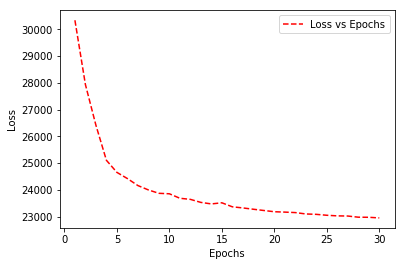

In [53]:
#Remove attention

from keras.models import Model 
from keras.layers import Average, Input, GRU, Dense, TimeDistributed, Add, Activation, RepeatVector, Flatten, Permute, Lambda, Multiply, Concatenate
from keras import backend as K
import matplotlib.pyplot as plt 

# a ----> attention of findings encoder
n_features = 100
epochs = 30
batch_size = 60

##ENCODER
encoder_inputs = Input(shape = (findings_MAXLEN,), dtype = 'int32')

encoder_embeds = embedding_layer(encoder_inputs)

forward_encoder_states, forward_h = GRU(100, return_sequences = True, return_state = True)(encoder_embeds) #return state is by default True
backward_encoder_states, backward_h = GRU(100, return_sequences = True, return_state = True, go_backwards = True)(encoder_embeds)

encoder_state = Concatenate()([forward_h, backward_h])

#__________#__________#__________#__________#__________#_________#__________#__________#_______________________________________________________

##DECODER
decoder_inputs = Input(shape = (impression_MAXLEN,), dtype = 'int32')

decoder_embeds = embedding_layer(decoder_inputs)

decoder_states,state_s = GRU(200, return_sequences = False, return_state = True)(decoder_embeds, initial_state = encoder_state)

decoder_outputs = Dense(impression_MAXLEN, activation = 'softmax')(decoder_states)

#_________#__________#___________#__________#__________#__________#__________#__________#______________________________________________________



model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

fit_model = model.fit([findings_data, impression_data], target_data, batch_size = batch_size, epochs = epochs, verbose = 1, shuffle = True, validation_split = 0.1)

model.save('vanilla.h5')

training_loss = fit_model.history['loss']

epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'r--')
plt.legend(['Loss vs Epochs'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
embedding_matrix[findings_data].shape

In [330]:
target_data

array([[ 464.,  889.,  164., ...,    0.,    0.,    0.],
       [ 597., 1817.,  328., ...,    0.,    0.,    0.],
       [ 464.,  889.,  164., ...,    0.,    0.,    0.],
       ...,
       [ 464.,  889.,  164., ...,    0.,    0.,    0.],
       [ 887., 1461.,  993., ...,    0.,    0.,    0.],
       [ 229., 1499., 1116., ...,    0.,    0.,    0.]], dtype=float32)